# Интерполяция и экстраполяция для таблично-заданных функций

## 1 В учебно-методических целях выполнить построение интерполяционного полинома Ньютона и расчет интерполяционного значения для демонстрационного задания на языке Python:

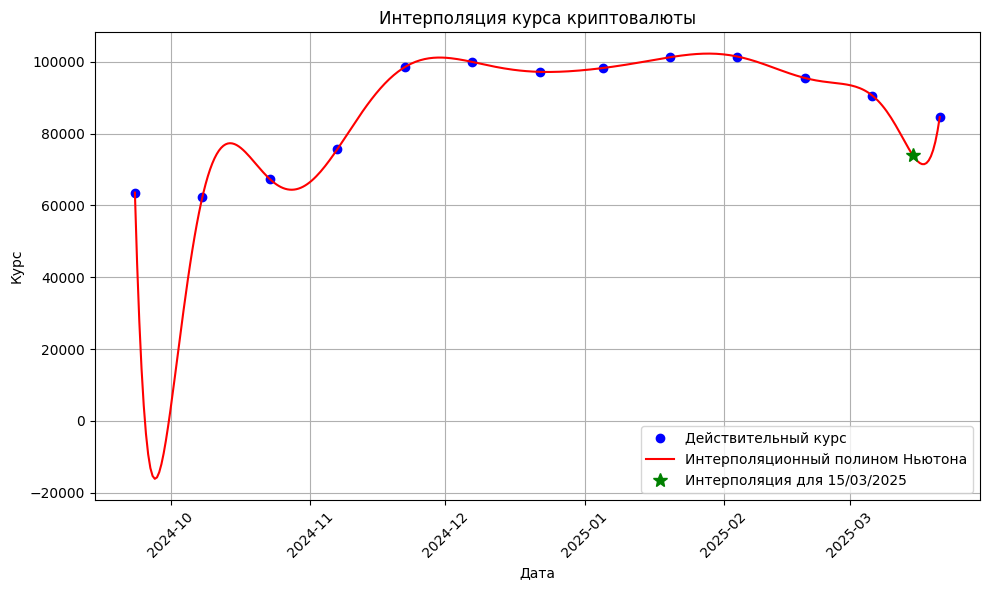

In [1]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

def calculate_days_since_start(dates_str):
	"""
	Преобразует строки с датами в объекты datetime и вычисляет количество дней с
	начальной даты.

	Параметры:
	- dates_str (list of str): Список строк, представляющих даты в формате "дд/мм/гггг".

	Возвращает:
	- list of datetime: Список объектов datetime, соответствующих входным строкам.
	- list of int: Список, содержащий количество дней с начальной даты для каждой даты.
	"""
	dates = [datetime.strptime(date, "%d/%m/%Y") for date in dates_str]
	start_date = dates[0]
	days_since_start = [(date - start_date).days for date in dates]
	return dates, days_since_start

def calculate_divided_differences(days, rates):
	"""
	Вычисляет коэффициенты для формулы интерполяции Ньютона с разделенными разностями.

	Параметры:
	- days (list of int): Список, содержащий количество дней с начальной даты.
	- rates (list of float): Курсы валют для соответствующих дат.

	Возвращает:
	- ndarray: Массив коэффициентов для интерполяции.
	"""
	num_points = len(rates)
	coefficients = np.zeros([num_points, num_points])
	coefficients[:,0] = rates

	for j in range(1, num_points):
		for i in range(num_points - j):
			coefficients[i][j] = (coefficients[i+1][j-1] -
								coefficients[i][j-1]) / (days[i+j] - days[i])
	return coefficients[0, :]

def newton_interpolation(x, days, coefficients):
	"""
	Выполняет интерполяцию по Ньютону для заданного дня.

	Параметры:
	- x (int): Количество дней от начальной даты, для которого требуется вычислить курс.
	- days (list of int): Список, содержащий количество дней с начальной даты
						для каждой даты.
	- coefficients (ndarray): Массив коэффициентов для интерполяции.

	Возвращает:
	- float: Интерполированное значение курса валюты для заданного дня.
	"""
	degree = len(coefficients) - 1
	result = coefficients[degree]

	for i in range(degree - 1, -1, -1):
		result = result * (x - days[i]) + coefficients[i]
	return result

# Исходные данные (bitcoin)
dates_str = ["23/09/2024","08/10/2024","23/10/2024","07/11/2024","22/11/2024",
			"07/12/2024","22/12/2024","05/01/2025","20/01/2025","04/02/2025",
			"19/02/2025","06/03/2025","21/03/2025"]

rates = [63582.59956924825,62287.39010510681,67351.04793512498,75620.88606963192,
		98509.11859102432,99973.85150659826,97202.82496847631,98256.73876849932,
		101275.33714814208,101466.8606657039,95495.89153299289,90604.08098523636,
		84620.78257505181]

# Обработка данных
dates, days_since_start = calculate_days_since_start(dates_str)
coefficients = calculate_divided_differences(days_since_start, rates)

# Выбор тестовой даты и интерполяция
test_date_str = "15/03/2025"
test_days_since_start = (datetime.strptime(test_date_str, "%d/%m/%Y") - dates[0]).days
interpolated_rate = newton_interpolation(test_days_since_start, days_since_start, coefficients)

# Подготовка данных для графика
interpolation_days = np.linspace(min(days_since_start), max(days_since_start), 365)
interpolated_rates = [newton_interpolation(day, days_since_start, coefficients) for day in interpolation_days]
interpolated_dates = [dates[0] + timedelta(days=day) for day in interpolation_days]

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, 'bo', label='Действительный курс')
plt.plot(interpolated_dates, interpolated_rates, 'r-', label='Интерполяционный полином Ньютона')
plt.plot(datetime.strptime(test_date_str, "%d/%m/%Y"), interpolated_rate, 'g*', markersize=10,
		label=f'Интерполяция для {test_date_str}')

plt.xlabel('Дата')
plt.ylabel('Курс')
plt.title('Интерполяция курса криптовалюты')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig('kurs.png', dpi=300)

## 2 Используем узлы Чебышёва, чтобы минимизировать ошибку интерполяции. А потом подготовим новую версию программы на языке Python.

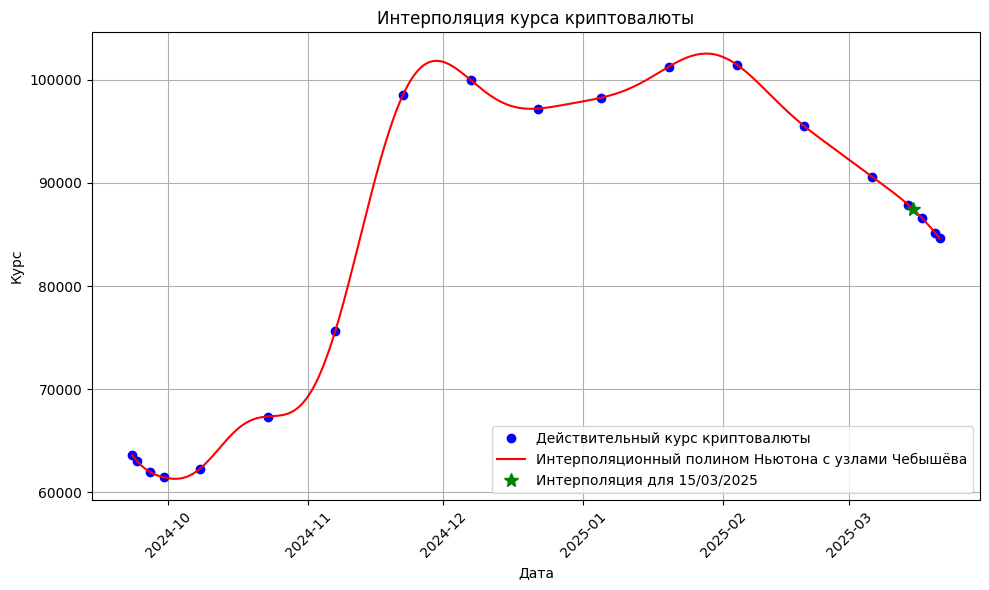

In [2]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def calculate_days_since_start(dates_str):
	"""
	Преобразует строки с датами в объекты datetime и вычисляет количество дней с начальной даты.

	Параметры:
	- dates_str (list of str): Список строк, представляющих даты в формате "дд/мм/гггг".

	Возвращает:
	- list of datetime: Список объектов datetime, соответствующих входным строкам.
	- list of int: Список, содержащий количество дней с начальной даты для каждой даты.
	"""
	dates = [datetime.strptime(date, "%d/%m/%Y") for date in dates_str]
	start_date = dates[0]
	days_since_start = [(date - start_date).days for date in dates]
	return dates, days_since_start

def calculate_divided_differences(days, rates):
	"""
	Вычисляет коэффициенты для формулы интерполяции Ньютона с разделенными разностями.

	Параметры:
	- days (list of int): Список, содержащий количество дней с начальной даты.
	- rates (list of float): Курсы валют для соответствующих дат.

	Возвращает:
	- ndarray: Массив коэффициентов для интерполяции.
	"""
	num_points = len(rates)
	coefficients = np.zeros([num_points, num_points])
	coefficients[:,0] = rates

	for j in range(1, num_points):
		for i in range(num_points - j):
			coefficients[i][j] = (coefficients[i+1][j-1] - coefficients[i][j-1]) / \
								(days[i+j] - days[i])
	return coefficients[0, :]

def newton_interpolation(x, days, coefficients):
	"""
	Выполняет интерполяцию по Ньютону для заданного дня.

	Параметры:
	- x (int): Количество дней от начальной даты, для которого требуется вычислить курс.
	- days (list of int): Список, содержащий количество дней с начальной даты для каждой даты.
	- coefficients (ndarray): Массив коэффициентов для интерполяции.

	Возвращает:
	- float: Интерполированное значение курса валюты для заданного дня.
	"""
	degree = len(coefficients) - 1
	result = coefficients[degree]

	for i in range(degree - 1, -1, -1):
		result = result * (x - days[i]) + coefficients[i]
	return result

def add_chebyshev_nodes(dates_str, rates, n, nodes=4):
	"""
	Добавляет новые даты с интерполированными значениями курсов, используя Чебышёвские узлы.
	Чебышёвские узлы вычисляются так, чтобы увеличить точность интерполяции на краях диапазона.

	Параметры:
	dates_str (list): Список строк дат в формате "дд/мм/гггг".
	rates (list): Список курсов, соответствующих датам.
	n (int): Общее количество Чебышёвских узлов для генерации.
	nodes (int): Количество узлов на каждом конце интервала

	Возвращает:
	tuple: Кортеж, содержащий список дат в формате "дд/мм/гггг" и список интерполированных курсов.
	"""
	# Преобразование строк дат в объекты datetime
	dates = [datetime.strptime(date, "%d/%m/%Y") for date in dates_str]
	start_date = dates[0]
	end_date = dates[-1]
	total_days = (end_date - start_date).days

	# Генерация Чебышёвских узлов
	chebyshev_points = np.cos(np.pi * (2 * np.arange(1, n + 1) - 1) / (2 * n))
	chebyshev_days = [int(0.5 * (total_days + 1) * (1 + pt)) for pt in chebyshev_points]

	# Ограничение по количеству узлов
	if len(chebyshev_days) > nodes * 2:
		chebyshev_days = chebyshev_days[:nodes] + chebyshev_days[-nodes:]
	chebyshev_days.sort()

	# Добавление новых дат, не включая существующие
	existing_days = [(date - start_date).days for date in dates]
	new_days = [day for day in chebyshev_days if day not in existing_days]

	# Добавление новых дат и их сортировка
	new_dates = [start_date + timedelta(days=day) for day in new_days]
	all_dates = sorted(dates + new_dates)

	# Интерполяция курсов
	interpolator = interp1d(existing_days, rates, kind='cubic', fill_value="extrapolate")
	all_rates = interpolator([(date - start_date).days for date in all_dates])

	return [date.strftime("%d/%m/%Y") for date in all_dates], all_rates.tolist()

# Исходные данные (bitcoin)
dates_str = ["23/09/2024","08/10/2024","23/10/2024","07/11/2024","22/11/2024",
			"07/12/2024","22/12/2024","05/01/2025","20/01/2025","04/02/2025",
			"19/02/2025","06/03/2025","21/03/2025"]

rates = [63582.59956924825,62287.39010510681,67351.04793512498,75620.88606963192,
		98509.11859102432,99973.85150659826,97202.82496847631,98256.73876849932,
		101275.33714814208,101466.8606657039,95495.89153299289,90604.08098523636,
		84620.78257505181]

n_additional_nodes = len(dates_str) * 2
dates_str, rates = add_chebyshev_nodes(dates_str, rates, n_additional_nodes)

# Обработка данных
dates, days_since_start = calculate_days_since_start(dates_str)
coefficients = calculate_divided_differences(days_since_start, rates)

# Выбор тестовой даты и интерполяция
test_date_str = "15/03/2025"
test_days_since_start = (datetime.strptime(test_date_str, "%d/%m/%Y") - dates[0]).days
interpolated_rate = newton_interpolation(test_days_since_start, days_since_start, coefficients)

# Подготовка данных для графика
interpolation_days = np.linspace(min(days_since_start), max(days_since_start), 365)
interpolated_rates = [newton_interpolation(day, days_since_start, coefficients) for day in interpolation_days]
interpolated_dates = [dates[0] + timedelta(days=day) for day in interpolation_days]

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, 'bo', label='Действительный курс криптовалюты')
plt.plot(interpolated_dates, interpolated_rates, 'r-',
		label='Интерполяционный полином Ньютона с узлами Чебышёва')
plt.plot(datetime.strptime(test_date_str, "%d/%m/%Y"), interpolated_rate, 'g*', markersize=10,
		label=f'Интерполяция для {test_date_str}')

plt.xlabel('Дата')
plt.ylabel('Курс')
plt.title('Интерполяция курса криптовалюты')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig('kurs_cheb.png', dpi=300)

## 3 Использовав данные индивидуального задания построить интерполяционный полином Ньютона. Выполнить расчет интерполяционного значения для произвольной даты, близкой к краю в интервале известных значений. Оценить ошибку интерполяции. Используйте узлы Чебышёва, чтобы минимизировать ошибку интерполяции (подготовить новую версию программы на языке Python). Все необходимые числовые результаты и графики отразить в отчете.

In [3]:
import pandas as pd

def calculate_days_since_start(dates):
    """
    Вычисляет количество дней с начальной даты.
    Возвращает список дней и начальную дату.
    """
    start_date = dates[0]
    days = [(date - start_date).days for date in dates]
    return days, start_date

def calculate_divided_differences(x, y):
    """
    Вычисляет разделенные разности для интерполяции Ньютона.
    """
    n = len(y)
    coef = np.zeros([n, n])
    coef[:,0] = y

    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j] - x[i])

    return coef[0, :]

def newton_interpolate(x, xi, coefs):
    """
    Выполняет интерполяцию с использованием полинома Ньютона.
    """
    n = len(coefs)
    result = coefs[-1]
    for i in range(n-2, -1, -1):
        result = result * (x - xi[i]) + coefs[i]
    return result

def add_chebyshev_nodes(x, y, num_nodes):
    """
    Добавляет новые узлы Чебышёва с интерполяцией значений.
    """
    a, b = min(x), max(x)
    k = np.arange(1, num_nodes+1)
    cheb_nodes = 0.5*(a + b) + 0.5*(b - a)*np.cos((2*k - 1)*np.pi/(2*num_nodes))

    interp = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    cheb_values = interp(cheb_nodes)

    new_x = np.sort(np.concatenate([x, cheb_nodes]))
    new_y = interp(new_x)

    return new_x, new_y

In [4]:
data = {
    'Дата': ["23/09/2024", "08/10/2024", "23/10/2024", "07/11/2024", "22/11/2024",
            "07/12/2024", "22/12/2024", "05/01/2025", "20/01/2025", "04/02/2025",
            "19/02/2025", "06/03/2025", "21/03/2025"],
    'Курс': [68.5224575461247, 64.8150717437226, 69.8400978102582, 71.0068203142269,
            89.4813830447918, 136.108213101719, 101.292135711878, 111.247381870912,
            115.898593106011, 106.681606421734, 129.374318120303, 104.709465983193,
            92.7462225279152]
}

df = pd.DataFrame(data)
df['Дата'] = pd.to_datetime(df['Дата'], format='%d/%m/%Y')

days, start_date = calculate_days_since_start(df['Дата'].dt.to_pydatetime())

coefs = calculate_divided_differences(days, df['Курс'].values)

test_date = datetime.strptime("20/03/2025", "%d/%m/%Y")
test_day = (test_date - start_date).days
interpolated_value = newton_interpolate(test_day, days, coefs)
actual_value = df.iloc[-1]['Курс']
error = abs(interpolated_value - actual_value)

new_days, new_rates = add_chebyshev_nodes(days, df['Курс'].values, num_nodes=6)
new_coefs = calculate_divided_differences(new_days, new_rates)
new_interpolated_value = newton_interpolate(test_day, new_days, new_coefs)
new_error = abs(new_interpolated_value - actual_value)

<ipython-input-4-498da746432f>:14: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  days, start_date = calculate_days_since_start(df['Дата'].dt.to_pydatetime())


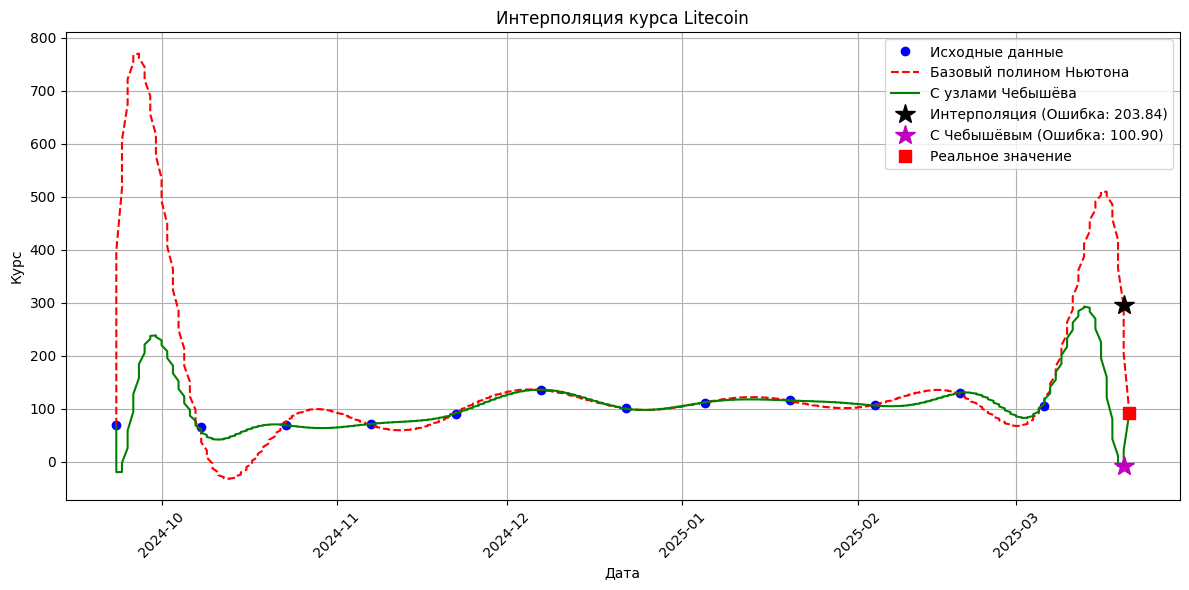


Результаты интерполяции:

                Метод  Интерполированное значение     Ошибка
              Базовый                  296.587266 203.841043
С Чебышёвскими узлами                   -8.152200 100.898422


In [6]:
plt.figure(figsize=(12, 6))

plt.plot(df['Дата'], df['Курс'], 'bo', label='Исходные данные')

x_vals = np.linspace(min(days), max(days), 365)
y_vals = [newton_interpolate(x, days, coefs) for x in x_vals]
dates = [start_date + timedelta(days=int(x)) for x in x_vals]
plt.plot(dates, y_vals, 'r--', label='Базовый полином Ньютона')

y_vals_cheb = [newton_interpolate(x, new_days, new_coefs) for x in x_vals]
plt.plot(dates, y_vals_cheb, 'g-', label='С узлами Чебышёва')

plt.plot(test_date, interpolated_value, 'k*', markersize=15, label=f'Интерполяция (Ошибка: {error:.2f})')
plt.plot(test_date, new_interpolated_value, 'm*', markersize=15, label=f'С Чебышёвым (Ошибка: {new_error:.2f})')
plt.plot(df['Дата'].iloc[-1], actual_value, 'rs', markersize=8, label='Реальное значение')

plt.title('Интерполяция курса Litecoin')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results = pd.DataFrame({
    'Метод': ['Базовый', 'С Чебышёвскими узлами'],
    'Интерполированное значение': [interpolated_value, new_interpolated_value],
    'Ошибка': [error, new_error]
})

print("\nРезультаты интерполяции:\n")
print(results.to_string(index=False))

## 4 Построить интерполяционный полином Лагранжа для своего индивидуального задания (подготовить код программы на языке Python). Предусмотреть оценку погрешности. Выполнить расчет интерполяционного значения для произвольной даты, близкой к краю в интервале известных значений. Используйте узлы Чебышёва, чтобы минимизировать ошибку интерполяции. Все необходимые числовые результаты и графики отразить в отчете. Сопоставить с результатами, полученными в предыдущем пункте.


In [23]:
import pandas as pd
from scipy.interpolate import CubicSpline

def lagrange_interpolation(x, x_points, y_points):
    """Интерполяция методом Лагранжа"""
    n = len(x_points)
    total = 0.0
    for i in range(n):
        term = y_points[i]
        for j in range(n):
            if i != j:
                denominator = x_points[i] - x_points[j]
                term *= (x - x_points[j]) / denominator
        total += term
    return total

def add_chebyshev_nodes(days, rates, num_nodes=6):
    """Добавление узлов Чебышёва"""
    a, b = min(days), max(days)
    k = np.arange(1, num_nodes + 1)
    cheb_days = 0.5*(a + b) + 0.5*(b - a)*np.cos((2*k - 1)*np.pi/(2*num_nodes))
    cheb_days = np.round(cheb_days).astype(int)

    new_days = np.setdiff1d(cheb_days, days)

    if len(new_days) > 0:
        cs = CubicSpline(days, rates)
        new_rates = cs(new_days)
        return np.sort(np.concatenate([days, new_days])), np.concatenate([rates, new_rates])
    return days.copy(), rates.copy()

data = {
    'Дата': ["23/09/2024", "08/10/2024", "23/10/2024", "07/11/2024", "22/11/2024",
            "07/12/2024", "22/12/2024", "05/01/2025", "20/01/2025", "04/02/2025",
            "19/02/2025", "06/03/2025", "21/03/2025"],
    'Курс': [68.5224575461247, 64.8150717437226, 69.8400978102582, 71.0068203142269,
            89.4813830447918, 136.108213101719, 101.292135711878, 111.247381870912,
            115.898593106011, 106.681606421734, 129.374318120303, 104.709465983193,
            92.7462225279152]
}

df = pd.DataFrame(data)
df['Дата'] = pd.to_datetime(df['Дата'], format='%d/%m/%Y')
start_date = df['Дата'].iloc[0]
df['Дни'] = (df['Дата'] - start_date).dt.days

test_date = "20/03/2025"
test_day = (datetime.strptime(test_date, "%d/%m/%Y") - start_date).days

days_base = df['Дни'].values
rates_base = df['Курс'].values
value_base = lagrange_interpolation(test_day, days_base, rates_base)
error_base = abs(value_base - df['Курс'].iloc[-1])

days_cheb, rates_cheb = add_chebyshev_nodes(days_base, rates_base, num_nodes=6)
value_cheb = lagrange_interpolation(test_day, days_cheb, rates_cheb)
error_cheb = abs(value_cheb - df['Курс'].iloc[-1])

x_vals = np.linspace(min(days_base), max(days_base), 500)
dates_vals = [start_date + timedelta(days=int(x)) for x in x_vals]

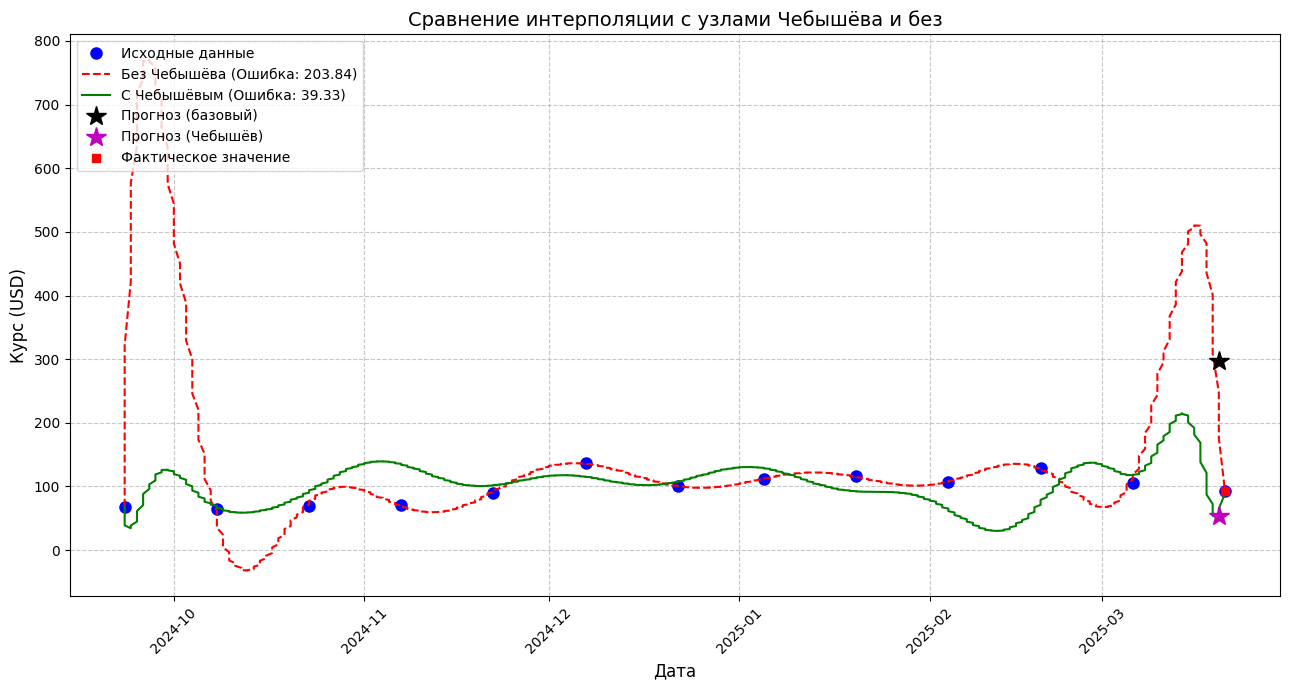

Результаты сравнения:
Метод		Прогноз		Ошибка
Базовый		296.59		203.84
С Чебышёвым	53.42		39.33
Фактическое значение: 92.75


In [24]:
plt.figure(figsize=(13, 7))
plt.plot(df['Дата'], df['Курс'], 'bo', markersize=8, label='Исходные данные')

y_base = [lagrange_interpolation(x, days_base, rates_base) for x in x_vals]
plt.plot(dates_vals, y_base, 'r--', label=f'Без Чебышёва (Ошибка: {error_base:.2f})')

y_cheb = [lagrange_interpolation(x, days_cheb, rates_cheb) for x in x_vals]
plt.plot(dates_vals, y_cheb, 'g-', label=f'С Чебышёвым (Ошибка: {error_cheb:.2f})')

plt.plot(datetime.strptime(test_date, "%d/%m/%Y"), value_base, 'k*',
         markersize=15, label='Прогноз (базовый)')
plt.plot(datetime.strptime(test_date, "%d/%m/%Y"), value_cheb, 'm*',
         markersize=15, label='Прогноз (Чебышёв)')
plt.plot(df['Дата'].iloc[-1], df['Курс'].iloc[-1], 'rs', label='Фактическое значение')

plt.title('Сравнение интерполяции с узлами Чебышёва и без', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Курс (USD)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Результаты сравнения:")
print(f"Метод\t\tПрогноз\t\tОшибка")
print(f"Базовый\t\t{value_base:.2f}\t\t{error_base:.2f}")
print(f"С Чебышёвым\t{value_cheb:.2f}\t\t{error_cheb:.2f}")
print(f"Фактическое значение: {df['Курс'].iloc[-1]:.2f}")

## 5 Творческое задание. Написать программу для экстраполяции таблично заданной функции своего индивидуального задания. При подготовке модели можно опираться на разнообразные априорные сведения и представления, обогащающие качество прогноза. Выполнить расчет экстраполяционного значения для текущей даты (даты выполнения лабораторной работы). Оценить ошибку экстраполяции (для получения точного значения следует использовать, например, данные из https://www.coingecko.com/). Для настройки режимов экстраполяции использовать метод кросс-валидации, который заключается в исключении части данных из набора и использовании оставшихся данных для подготовки расчетной модели. В этом случае возможна проверка, насколько хорошо модель предсказывает исключенные данные. В упрощенном случае можно, например, исключить последние несколько точек, построить модель без них, а затем проверить, насколько хорошо модель предсказывает исключенные точки. Все необходимые числовые результаты и графики отразить в отчете.


In [45]:
import numpy
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

In [46]:
def load_data():
    data = {
        'Дата': ["23/09/2024", "08/10/2024", "23/10/2024", "07/11/2024", "22/11/2024",
                "07/12/2024", "22/12/2024", "05/01/2025", "20/01/2025", "04/02/2025",
                "19/02/2025", "06/03/2025", "21/03/2025"],
        'Курс': [68.52, 64.81, 69.84, 71.01, 89.48, 136.11, 101.29, 111.25,
                115.90, 106.68, 129.37, 104.71, 92.75]
    }
    df = pd.DataFrame(data)
    df['Дата'] = pd.to_datetime(df['Дата'], format='%d/%m/%Y')
    df = df.sort_values('Дата').reset_index(drop=True)
    return df

def create_features(df, window=3):
    df = df.copy()
    for i in range(1, window+1):
        df[f'lag_{i}'] = df['Курс'].shift(i)
    df['rolling_mean'] = df['Курс'].rolling(window).mean()
    return df.dropna()

def cross_validate(df, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    for fold, (train_index, test_index) in enumerate(tscv.split(df)):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        try:
            arima_model = ARIMA(train_data['Курс'], order=(1,1,1)).fit()
            arima_pred = arima_model.forecast(steps=len(test_data))
            arima_mae = mean_absolute_error(test_data['Курс'], arima_pred)
            results.append({'model': 'ARIMA', 'fold': fold, 'mae': arima_mae})
        except Exception as e:
            print(f"ARIMA ошибка на фолде {fold}: {str(e)}")

        try:
            ets_model = ExponentialSmoothing(train_data['Курс']).fit()
            ets_pred = ets_model.forecast(len(test_data))
            ets_mae = mean_absolute_error(test_data['Курс'], ets_pred)
            results.append({'model': 'ETS', 'fold': fold, 'mae': ets_mae})
        except Exception as e:
            print(f"ETS ошибка на фолде {fold}: {str(e)}")

        try:
            prophet_df = train_data[['Дата', 'Курс']].rename(columns={'Дата': 'ds', 'Курс': 'y'})
            prophet_model = Prophet().fit(prophet_df)
            future = prophet_model.make_future_dataframe(periods=len(test_data))
            prophet_pred = prophet_model.predict(future)['yhat'].values[-len(test_data):]
            prophet_mae = mean_absolute_error(test_data['Курс'], prophet_pred)
            results.append({'model': 'Prophet', 'fold': fold, 'mae': prophet_mae})
        except Exception as e:
            print(f"Prophet ошибка на фолде {fold}: {str(e)}")

    return pd.DataFrame(results)

def visualize_results(results_df, df):
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    models_mae = results_df.groupby('model')['mae'].mean()
    models_mae.sort_values().plot(kind='barh', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Средняя абсолютная ошибка (MAE) по моделям')
    plt.xlabel('Ошибка MAE')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(df['Дата'], df['Курс'], 'o-', label='Фактические значения', markersize=8)

    last_date = df['Дата'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date, periods=6)[1:]

    arima_model = ARIMA(df['Курс'], order=(1,1,1)).fit()
    arima_forecast = arima_model.forecast(steps=5)
    plt.plot(forecast_dates, arima_forecast, 's--', label='ARIMA прогноз')

    ets_model = ExponentialSmoothing(df['Курс']).fit()
    ets_forecast = ets_model.forecast(5)
    plt.plot(forecast_dates, ets_forecast, '^--', label='ETS прогноз')

    prophet_model = Prophet().fit(df.rename(columns={'Дата': 'ds', 'Курс': 'y'}))
    future = prophet_model.make_future_dataframe(periods=5)
    prophet_forecast = prophet_model.predict(future)['yhat'].values[-5:]
    plt.plot(forecast_dates, prophet_forecast, 'd--', label='Prophet прогноз')

    plt.title('Прогноз курса на следующие 5 дней')
    plt.xlabel('Дата')
    plt.ylabel('Курс')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.subplot(2, 1, 2)
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        plt.plot(model_data['fold'], model_data['mae'], 'o-', label=model)

    plt.title('Распределение ошибок по фолдам кросс-валидации')
    plt.xlabel('Номер фолда')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(results_df['fold'].nunique()))

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA

Результаты кросс-валидации:
model
ETS        12.286803
Prophet    15.767196
ARIMA      16.275932


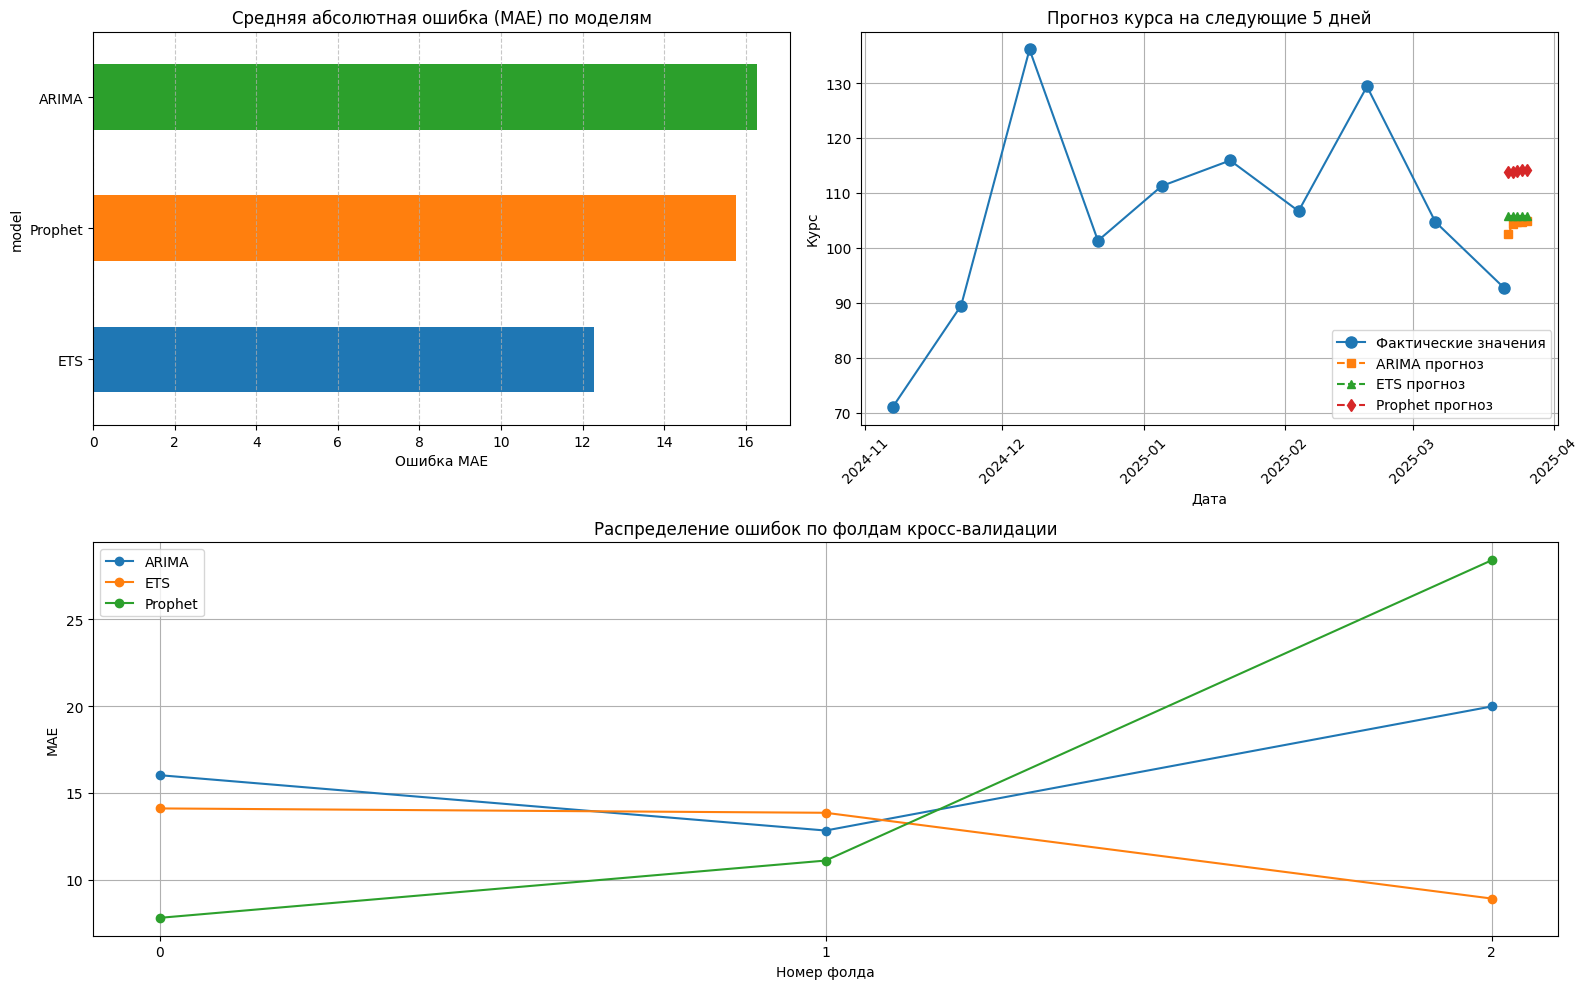

In [47]:
df = load_data()
df = create_features(df)
results_df = cross_validate(df)

print("Результаты кросс-валидации:")
print(results_df.groupby('model')['mae'].mean().sort_values().to_string())

visualize_results(results_df, df)